<a href="https://colab.research.google.com/github/Kravty/MachineLearning/blob/main/GAN_Fashion_MNIST_TensorFlow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> This notebooks uses simple model based on GAN (Generative Adversarial Networks) idea to create the set of fake images similar to the original Fashion MNIST dataset.

<h3> Import of libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
from skimage.io import imread

<h3> Data preparation 

In [2]:
# Loading the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
# Scaling input data to the range between -1 and 1 to improve training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

# Checking if the dimensions of input data are suitable for the model
print(f"Size of the train data is: {x_train.shape}")

Size of the train data is: (60000, 28, 28)


In [4]:
# Flattening the input data to obtain tabular data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [5]:
# Dimensionality of the latent space (hyperparameter)
latent_dim = 100

In [6]:
# Function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

<h3> Building the model

In [7]:
# Function for building generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [8]:
# Function for building discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

Compiling generator and discriminator models amd combining them into GAN model

In [9]:
# Compiling the discriminator model
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# Building the generator model
generator = build_generator(latent_dim)

# Creating an input to represent noise sample from latent space
n = Input(shape=(latent_dim,))

# Passing the noise through generator to get an image (functional API)
img = generator(n)

# Freezing weights of the discriminator
discriminator.trainable = False

# The true output will be fake, but will be labeled as real
fake_pred = discriminator(img)

# Combining both models and compiling it
combined_model = Model(n, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

<h3> Training the model

In [10]:
# Parameters of the training
batch_size = 32
epochs = 50000
sample_period = 200   # After each 'sample_period' the data will be saved


# Creating batch labels for calling 'train_on_batch' function
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Variables to store the losses
d_losses = []
g_losses = []

In [11]:
# Creating a folder for storing generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
# Function for generating a grid of random samples from the generator
# The output will be an image containing 4x4 generated images (results checking)
def sample_images(epoch):
  rows, cols = 4, 4
  # Generating random noise vectors from the latent space (previously 'n')
  noise = np.random.randn(rows * cols, latent_dim)
  # Getting the generated samples
  imgs = generator.predict(noise)
  # Variable for indexing
  idx = 0

  # Rescaling images to the range between 0 and 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  
  # Saving the generated samples
  fig.savefig(f"gan_images/{epoch}.png")
  
  plt.close()

In [13]:
# Training loop
for epoch in range(epochs):
  
  # Training discriminator
  
  # Selecting a random batch of real images from dataset
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generating the fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Obtaining losses and accuracies
  # Positive class
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  # Negative class
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  # Calculating the mean of both
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  # Training generator
  
  # Generating noise
  noise = np.random.randn(batch_size, latent_dim)
  # Goal of the generator is to 'trick' discriminator that generated images are real
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Saving the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % sample_period == 0:
    # Saving the png file containing images from 'sample_images' function
    sample_images(epoch)
    # Informations after given step of training
    print(f"epoch: {epoch+1}/{epochs}, d_acc: {d_acc:.2f}, d_loss: {d_loss:.2f}, \
g_loss: {g_loss:.2f}")

epoch: 1/50000, d_acc: 0.34, d_loss: 0.75, g_loss: 0.52
epoch: 201/50000, d_acc: 0.92, d_loss: 0.17, g_loss: 4.00
epoch: 401/50000, d_acc: 0.70, d_loss: 0.63, g_loss: 1.18
epoch: 601/50000, d_acc: 0.75, d_loss: 0.62, g_loss: 1.06
epoch: 801/50000, d_acc: 0.66, d_loss: 0.57, g_loss: 1.10
epoch: 1001/50000, d_acc: 0.70, d_loss: 0.56, g_loss: 0.97
epoch: 1201/50000, d_acc: 0.78, d_loss: 0.56, g_loss: 0.94
epoch: 1401/50000, d_acc: 0.58, d_loss: 0.69, g_loss: 0.89
epoch: 1601/50000, d_acc: 0.61, d_loss: 0.61, g_loss: 0.96
epoch: 1801/50000, d_acc: 0.69, d_loss: 0.62, g_loss: 0.94
epoch: 2001/50000, d_acc: 0.62, d_loss: 0.66, g_loss: 0.96
epoch: 2201/50000, d_acc: 0.84, d_loss: 0.52, g_loss: 0.92
epoch: 2401/50000, d_acc: 0.67, d_loss: 0.61, g_loss: 1.01
epoch: 2601/50000, d_acc: 0.58, d_loss: 0.64, g_loss: 0.93
epoch: 2801/50000, d_acc: 0.61, d_loss: 0.69, g_loss: 0.94
epoch: 3001/50000, d_acc: 0.69, d_loss: 0.61, g_loss: 0.98
epoch: 3201/50000, d_acc: 0.70, d_loss: 0.59, g_loss: 1.07
epoc

In [14]:
# Saving image after final epoch
sample_images(epoch)

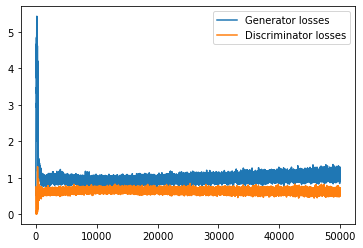

In [15]:
# Plotting losses
plt.plot(g_losses, label='Generator losses')
plt.plot(d_losses, label='Discriminator losses')
plt.legend();

<h3> Plotting generated images at different stages

Initial generated image


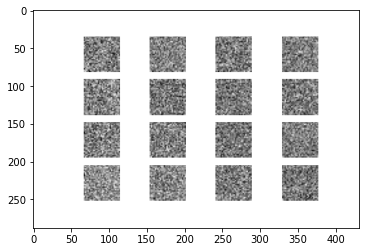

In [16]:
print('Initial generated image')
im = imread('gan_images/0.png')
plt.imshow(im);

Generated image after 1 000 epochs


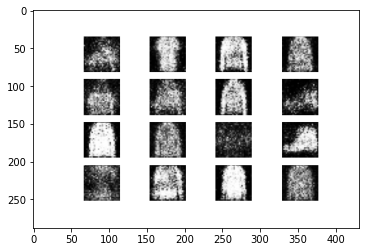

In [17]:
print('Generated image after 1 000 epochs')
im = imread('gan_images/1000.png')
plt.imshow(im);

Generated image after 5 000 epochs


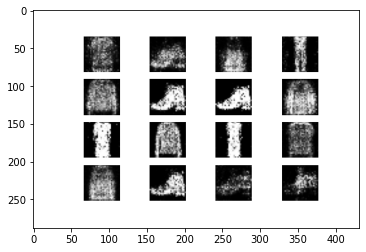

In [18]:
print('Generated image after 5 000 epochs')
im = imread('gan_images/5000.png')
plt.imshow(im);

Generated image after 10 000 epochs


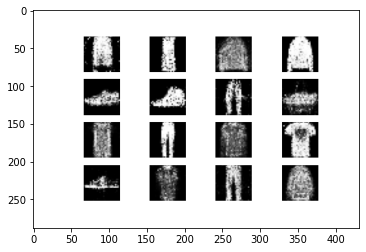

In [19]:
print('Generated image after 10 000 epochs')
im = imread('gan_images/10000.png')
plt.imshow(im);

Generated image after 20 000 epochs


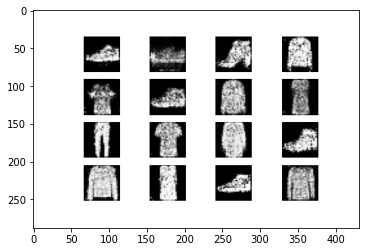

In [20]:
print('Generated image after 20 000 epochs')
im = imread('gan_images/20000.png')
plt.imshow(im);

Generated image after 30 000 epochs


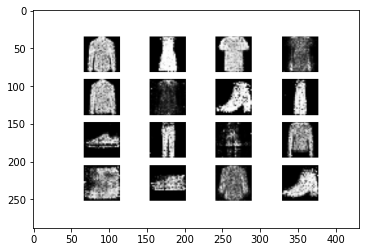

In [21]:
print('Generated image after 30 000 epochs')
im = imread('gan_images/30000.png')
plt.imshow(im);

Generated image after final epoch (50 000)


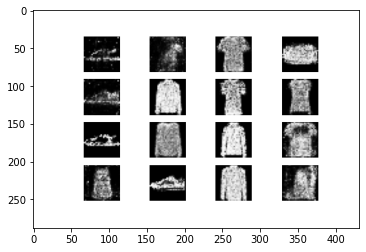

In [22]:
print('Generated image after final epoch (50 000)')
im = imread('gan_images/49999.png')
plt.imshow(im);